In [1]:
import pandas as pd
import plotly.graph_objects as go
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, UniqueConstraint
from sqlalchemy.orm import declarative_base, sessionmaker
from sqlalchemy.exc import IntegrityError
import yfinance as yf

In [2]:
# Read the CSV file
csv_file_path = 'NIFTY_200_with_Yahoo_Symbols.csv'
df = pd.read_csv(csv_file_path)
df

SYMBOL   YAHOO_SYMBOL
0         PAYTM       PAYTM.NS
1    SHRIRAMFIN  SHRIRAMFIN.NS
2    BHARATFORG  BHARATFORG.NS
3       MPHASIS     MPHASIS.NS
4      ASHOKLEY    ASHOKLEY.NS
..          ...            ...
196    UNITDSPR    UNITDSPR.NS
197       DMART       DMART.NS
198  FEDERALBNK  FEDERALBNK.NS
199        RVNL        RVNL.NS
200     MANKIND     MANKIND.NS

[201 rows x 2 columns]

In [3]:
# SQLAlchemy setup
db_file_path = 'sqlite:///finance_symbols.db'
engine = create_engine(db_file_path, echo=False)
Base = declarative_base()

In [4]:
# Define the Symbols table
class Symbol(Base):
    __tablename__ = 'symbols'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String)
    yahoo_symbol = Column(String, unique=True)
    __table_args__ = (UniqueConstraint('yahoo_symbol', name='_yahoo_symbol_uc'),)

# Define the Data table
class FinanceData(Base):
    __tablename__ = 'finance_data'
    id = Column(Integer, primary_key=True, autoincrement=True)
    symbol = Column(String)
    date = Column(Date)
    open = Column(Float)
    high = Column(Float)
    low = Column(Float)
    close = Column(Float)
    volume = Column(Float)
    __table_args__ = (UniqueConstraint('symbol', 'date', name='_symbol_date_uc'),)

Base.metadata.create_all(engine)
Session = sessionmaker(bind=engine)
session = Session()

In [5]:
# Insert or update symbols in the database
inserted_symbols = 0
updated_symbols = 0
for index, row in df.iterrows():
    name = row['SYMBOL']
    yahoo_symbol = row['YAHOO_SYMBOL']
    
    symbol = session.query(Symbol).filter_by(yahoo_symbol=yahoo_symbol).first()
    
    if symbol:
        symbol.name = name
        updated_symbols += 1
    else:
        new_symbol = Symbol(name=name, yahoo_symbol=yahoo_symbol)
        session.add(new_symbol)
        inserted_symbols += 1

session.commit()
print(f'Inserted {inserted_symbols} new symbols.')
print(f'Updated {updated_symbols} existing symbols.')

Inserted 201 new symbols.
Updated 0 existing symbols.


In [11]:
import yfinance as yf
meta = yf.Ticker("META")
print(meta.info)

429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/META?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=META&crumb=Edge%3A+Too+Many+Requests


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [10]:
!pip install pandas_datareader yfinance
import pandas_datareader as pdr
from datetime import datetime

ibm = pdr.get_data_yahoo(symbols='IBM', start=datetime(2000, 1, 1), end=datetime(2012, 1, 1))
print(ibm['Adj Close'])

RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/IBM/history?period1=946679400&period2=1325456999&interval=1d&frequency=1d&filter=history
Response Text:
b'<html><meta charset=\'utf-8\'>\n<script>\nif(window != window.top){\ndocument.write(\'<p>Content is currently unavailable.</p><img src="//geo.yahoo.com/p?s=1197757039&t=\'\n    + new Date().getTime() + \'&_R=\'\n    + encodeURIComponent(document.referrer)\n    + \'&err=404\'\n    + \'" width="0px" height="0px"/>\');\n}else{\nwindow.location.replace(\'https://\' + window.location.host + \'/?err=404\');\n}\n</script>\n<noscript>\n<META http-equiv="refresh" content="0;URL=https://finance.yahoo.com/?err=404">\n</noscript></html>'

In [6]:
# Fetch and insert/update yfinance data
inserted_data = 0
updated_data = 0
failed_downloads = []

for yahoo_symbol in df['YAHOO_SYMBOL']:
    try:
        data = yf.download(yahoo_symbol, start='1994-01-01', end='2024-01-01')
        for date, row in data.iterrows():
            finance_data = session.query(FinanceData).filter_by(symbol=yahoo_symbol, date=date).first()
            if finance_data:
                finance_data.open = row['Open']
                finance_data.high = row['High']
                finance_data.low = row['Low']
                finance_data.close = row['Close']
                finance_data.volume = row['Volume']
                updated_data += 1
            else:
                new_finance_data = FinanceData(
                    symbol=yahoo_symbol,
                    date=date,
                    open=row['Open'],
                    high=row['High'],
                    low=row['Low'],
                    close=row['Close'],
                    volume=row['Volume']
                )
                session.add(new_finance_data)
                inserted_data += 1
        print(f'Successfully downloaded data for {yahoo_symbol}')
    except Exception as e:
        print(f'Failed to download data for {yahoo_symbol}: {e}')
        failed_downloads.append(yahoo_symbol)

session.commit()

# Print final status
print(f'Inserted {inserted_data} new data entries.')
print(f'Updated {updated_data} existing data entries.')

Failed to get ticker 'PAYTM.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PAYTM.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for PAYTM.NS


Failed to get ticker 'SHRIRAMFIN.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SHRIRAMFIN.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for SHRIRAMFIN.NS


Failed to get ticker 'BHARATFORG.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BHARATFORG.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for BHARATFORG.NS


Failed to get ticker 'MPHASIS.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['MPHASIS.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for MPHASIS.NS


Failed to get ticker 'ASHOKLEY.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ASHOKLEY.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for ASHOKLEY.NS


Failed to get ticker 'PEL.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PEL.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for PEL.NS


Failed to get ticker 'CIPLA.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CIPLA.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for CIPLA.NS


Failed to get ticker 'DIVISLAB.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DIVISLAB.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for DIVISLAB.NS


Failed to get ticker 'IDEA.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['IDEA.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for IDEA.NS


Failed to get ticker 'PIIND.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PIIND.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for PIIND.NS


Failed to get ticker 'TATAPOWER.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TATAPOWER.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for TATAPOWER.NS


Failed to get ticker 'INDUSTOWER.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['INDUSTOWER.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for INDUSTOWER.NS


Failed to get ticker 'SJVN.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SJVN.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for SJVN.NS


Failed to get ticker 'DELHIVERY.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DELHIVERY.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for DELHIVERY.NS


Failed to get ticker 'BHARTIARTL.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BHARTIARTL.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for BHARTIARTL.NS


Failed to get ticker 'APOLLOHOSP.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['APOLLOHOSP.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for APOLLOHOSP.NS


Failed to get ticker 'LAURUSLABS.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LAURUSLABS.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for LAURUSLABS.NS


Failed to get ticker 'LTF.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LTF.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for LTF.NS


Failed to get ticker 'BALKRISIND.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BALKRISIND.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for BALKRISIND.NS


Failed to get ticker 'INDHOTEL.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['INDHOTEL.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for INDHOTEL.NS


Failed to get ticker 'VEDL.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VEDL.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for VEDL.NS


Failed to get ticker 'JSWENERGY.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['JSWENERGY.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for JSWENERGY.NS


Failed to get ticker 'JINDALSTEL.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['JINDALSTEL.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for JINDALSTEL.NS


Failed to get ticker 'BANDHANBNK.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BANDHANBNK.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for BANDHANBNK.NS


Failed to get ticker 'ADANIPORTS.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ADANIPORTS.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for ADANIPORTS.NS


Failed to get ticker 'CHOLAFIN.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CHOLAFIN.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for CHOLAFIN.NS


Failed to get ticker 'GMRINFRA.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GMRINFRA.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for GMRINFRA.NS


Failed to get ticker 'NMDC.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['NMDC.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for NMDC.NS


Failed to get ticker 'WIPRO.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['WIPRO.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for WIPRO.NS


Failed to get ticker 'OBEROIRLTY.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['OBEROIRLTY.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for OBEROIRLTY.NS


Failed to get ticker 'SAIL.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SAIL.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for SAIL.NS


Failed to get ticker 'TATASTEEL.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TATASTEEL.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for TATASTEEL.NS


Failed to get ticker 'ADANIENT.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ADANIENT.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for ADANIENT.NS


Failed to get ticker 'SUNPHARMA.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['SUNPHARMA.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for SUNPHARMA.NS


Failed to get ticker 'DIXON.NS' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DIXON.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Successfully downloaded data for DIXON.NS


KeyboardInterrupt: 

Failed to get ticker 'SBILIFE.NS' reason: Expecting value: line 1 column 1 (char 0)


In [14]:
# Print final status
print(f'Inserted {inserted_data} new data entries.')
print(f'Updated {updated_data} existing data entries.')
if failed_downloads:
    print('Failed to download data for the following symbols:')
    for symbol in failed_downloads:
        print(symbol)

session.close()


Inserted 862433 new data entries.
Updated 0 existing data entries.


In [9]:
# Retrieve and print the list of symbols from the database
symbols_in_db = session.query(Symbol).all()
print("List of symbols from the database:")
for symbol in symbols_in_db:
    print(f"ID: {symbol.id}, Name: {symbol.name}, Yahoo Symbol: {symbol.yahoo_symbol}")

session.close()

List of symbols from the database:
ID: 1, Name: PAYTM, Yahoo Symbol: PAYTM.NS
ID: 2, Name: SHRIRAMFIN, Yahoo Symbol: SHRIRAMFIN.NS
ID: 3, Name: BHARATFORG, Yahoo Symbol: BHARATFORG.NS
ID: 4, Name: MPHASIS, Yahoo Symbol: MPHASIS.NS
ID: 5, Name: ASHOKLEY, Yahoo Symbol: ASHOKLEY.NS
ID: 6, Name: PEL, Yahoo Symbol: PEL.NS
ID: 7, Name: CIPLA, Yahoo Symbol: CIPLA.NS
ID: 8, Name: DIVISLAB, Yahoo Symbol: DIVISLAB.NS
ID: 9, Name: IDEA, Yahoo Symbol: IDEA.NS
ID: 10, Name: PIIND, Yahoo Symbol: PIIND.NS
ID: 11, Name: TATAPOWER, Yahoo Symbol: TATAPOWER.NS
ID: 12, Name: INDUSTOWER, Yahoo Symbol: INDUSTOWER.NS
ID: 13, Name: SJVN, Yahoo Symbol: SJVN.NS
ID: 14, Name: DELHIVERY, Yahoo Symbol: DELHIVERY.NS
ID: 15, Name: BHARTIARTL, Yahoo Symbol: BHARTIARTL.NS
ID: 16, Name: APOLLOHOSP, Yahoo Symbol: APOLLOHOSP.NS
ID: 17, Name: LAURUSLABS, Yahoo Symbol: LAURUSLABS.NS
ID: 18, Name: LTF, Yahoo Symbol: LTF.NS
ID: 19, Name: BALKRISIND, Yahoo Symbol: BALKRISIND.NS
ID: 20, Name: INDHOTEL, Yahoo Symbol: INDHOTEL.N

In [10]:
from sqlalchemy import func

# SQLAlchemy setup
db_file_path = 'sqlite:///finance_symbols.db'
engine = create_engine(db_file_path, echo=False)
Base = declarative_base()

# Define the FinanceData table
class FinanceData(Base):
    __tablename__ = 'finance_data'
    id = Column(Integer, primary_key=True, autoincrement=True)
    symbol = Column(String)
    date = Column(Date)
    open = Column(Float)
    high = Column(Float)
    low = Column(Float)
    close = Column(Float)
    volume = Column(Float)
    __table_args__ = (UniqueConstraint('symbol', 'date', name='_symbol_date_uc'),)

Base.metadata.create_all(engine)
Session = sessionmaker(bind=engine)
session = Session()

# Query to get unique symbols and their count
unique_symbols = session.query(FinanceData.symbol).distinct().all()
unique_symbols_count = len(unique_symbols)

# Print the total number of symbols and the list of symbols
print(f"Total Symbols are: {unique_symbols_count}\n")
print("The List of Symbols are:")
for idx, (symbol,) in enumerate(unique_symbols, start=1):
    print(f"{idx}. {symbol}")

session.close()


Total Symbols are: 200

The List of Symbols are:
1. ABB.NS
2. ABCAPITAL.NS
3. ABFRL.NS
4. ACC.NS
5. ADANIENSOL.NS
6. ADANIENT.NS
7. ADANIGREEN.NS
8. ADANIPORTS.NS
9. ADANIPOWER.NS
10. ALKEM.NS
11. AMBUJACEM.NS
12. APLAPOLLO.NS
13. APOLLOHOSP.NS
14. APOLLOTYRE.NS
15. ASHOKLEY.NS
16. ASIANPAINT.NS
17. ASTRAL.NS
18. ATGL.NS
19. AUBANK.NS
20. AUROPHARMA.NS
21. AXISBANK.NS
22. BAJAJ-AUTO.NS
23. BAJAJFINSV.NS
24. BAJAJHLDNG.NS
25. BAJFINANCE.NS
26. BALKRISIND.NS
27. BANDHANBNK.NS
28. BANKBARODA.NS
29. BANKINDIA.NS
30. BDL.NS
31. BEL.NS
32. BERGEPAINT.NS
33. BHARATFORG.NS
34. BHARTIARTL.NS
35. BHEL.NS
36. BIOCON.NS
37. BOSCHLTD.NS
38. BPCL.NS
39. BRITANNIA.NS
40. BSE.NS
41. CANBK.NS
42. CGPOWER.NS
43. CHOLAFIN.NS
44. CIPLA.NS
45. COALINDIA.NS
46. COFORGE.NS
47. COLPAL.NS
48. CONCOR.NS
49. CUMMINSIND.NS
50. DABUR.NS
51. DALBHARAT.NS
52. DEEPAKNTR.NS
53. DELHIVERY.NS
54. DIVISLAB.NS
55. DIXON.NS
56. DLF.NS
57. DMART.NS
58. DRREDDY.NS
59. EICHERMOT.NS
60. ESCORTS.NS
61. FACT.NS
62. FEDERALBNK.NS

In [18]:
# Query to get data for the symbol "RELIANCE.NS"
symbol_to_plot = "RELIANCE.NS"
data = session.query(FinanceData).filter_by(symbol=symbol_to_plot).all()

# Convert the queried data to a pandas DataFrame
data_df = pd.DataFrame([(d.date, d.open, d.high, d.low, d.close, d.volume) for d in data],
                       columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Set the date as the index
data_df.set_index('Date', inplace=True)

# Plot the data using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data_df.index,
    y=data_df['Close'],
    mode='lines',
    name='Close Price'
))

fig.update_layout(
    title=f'Close Price of {symbol_to_plot} Over Time',
    xaxis_title='Date',
    yaxis_title='Close Price',
    template='plotly_dark'
)

fig.show()

session.close()

In [25]:
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, UniqueConstraint, func
from sqlalchemy.orm import declarative_base, sessionmaker

# SQLAlchemy setup
db_file_path = 'sqlite:///finance_symbols.db'
engine = create_engine(db_file_path, echo=False)
Base = declarative_base()

# Define the FinanceData table
class FinanceData(Base):
    __tablename__ = 'finance_data'
    id = Column(Integer, primary_key=True, autoincrement=True)
    symbol = Column(String)
    date = Column(Date)
    open = Column(Float)
    high = Column(Float)
    low = Column(Float)
    close = Column(Float)
    volume = Column(Float)
    __table_args__ = (UniqueConstraint('symbol', 'date', name='_symbol_date_uc'),)

Base.metadata.create_all(engine)
Session = sessionmaker(bind=engine)
session = Session()

# Query to get the count of records for each symbol
symbol_counts = session.query(FinanceData.symbol, func.count(FinanceData.id)).group_by(FinanceData.symbol).all()

# Print the count of records for each symbol
print("Number of records for each symbol:")
for symbol, count in symbol_counts:
    print(f"Symbol: {symbol}, Count: {count}")

session.close()


Number of records for each symbol:
Symbol: ABB.NS, Count: 5343
Symbol: ABCAPITAL.NS, Count: 1564
Symbol: ABFRL.NS, Count: 2577
Symbol: ACC.NS, Count: 5340
Symbol: ADANIENSOL.NS, Count: 92
Symbol: ADANIENT.NS, Count: 5342
Symbol: ADANIGREEN.NS, Count: 1367
Symbol: ADANIPORTS.NS, Count: 3966
Symbol: ADANIPOWER.NS, Count: 3543
Symbol: ALKEM.NS, Count: 1981
Symbol: AMBUJACEM.NS, Count: 5341
Symbol: APLAPOLLO.NS, Count: 2971
Symbol: APOLLOHOSP.NS, Count: 5340
Symbol: APOLLOTYRE.NS, Count: 5472
Symbol: ASHOKLEY.NS, Count: 5342
Symbol: ASIANPAINT.NS, Count: 5340
Symbol: ASTRAL.NS, Count: 4139
Symbol: ATGL.NS, Count: 1273
Symbol: AUBANK.NS, Count: 1600
Symbol: AUROPHARMA.NS, Count: 7026
Symbol: AXISBANK.NS, Count: 6276
Symbol: BAJAJ-AUTO.NS, Count: 5343
Symbol: BAJAJFINSV.NS, Count: 5309
Symbol: BAJAJHLDNG.NS, Count: 5309
Symbol: BAJFINANCE.NS, Count: 5340
Symbol: BALKRISIND.NS, Count: 4421
Symbol: BANDHANBNK.NS, Count: 1423
Symbol: BANKBARODA.NS, Count: 5340
Symbol: BANKINDIA.NS, Count: 5340


In [34]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sqlalchemy import create_engine
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# SQLAlchemy setup
db_file_path = 'sqlite:///finance_symbols.db'
engine = create_engine(db_file_path, echo=False)

In [35]:
# Function to create features using pandas_ta
def create_features(df):
    # Calculate returns and previous day returns
    df['returns'] = df['close'].pct_change()
    df['prev_day_returns'] = df['returns'].shift(1)
    
    # Calculate EMAs
    df['ema5'] = ta.ema(df['close'], length=5)
    df['ema10'] = ta.ema(df['close'], length=10)
    
    # Calculate high+low/2 and high+low+close/3
    df['hl2'] = (df['high'] + df['low']) / 2
    df['hlc3'] = (df['high'] + df['low'] + df['close']) / 3
    
    # Calculate RSI
    df['rsi'] = ta.rsi(df['close'], length=14)
    
    # Calculate ATR
    df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=14)
    
    # Drop rows with NaN values
    df.dropna(inplace=True)
    
    return df


In [41]:
# Function to calculate RSI
def calculate_rsi(prices, period=14):
    deltas = np.diff(prices)
    seed = deltas[:period+1]
    up = seed[seed >= 0].sum()/period
    down = -seed[seed < 0].sum()/period
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:period] = 100. - 100./(1. + rs)

    for i in range(period, len(prices)):
        delta = deltas[i - 1]
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)

    return rsi

# Function to calculate ATR
def calculate_atr(high, low, close, period=14):
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.ewm(alpha=1/period, adjust=False).mean()
    return atr

In [44]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from sqlalchemy import create_engine
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# ... (keep all the previous functions and setup code) ...

def train_and_predict(symbol, days=30):
    # Load data from SQLite
    query = f"SELECT * FROM finance_data WHERE symbol = '{symbol}' ORDER BY date"
    df = pd.read_sql(query, engine)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Create features
    df = create_features(df)
    
    # Prepare features and target
    features = ['open', 'high', 'low', 'volume', 'returns', 'prev_day_returns', 'ema5', 'ema10', 'hl2', 'hlc3', 'rsi', 'atr']
    X = df[features]
    y = df['close']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train CatBoost model
    model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, random_state=42)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    
    # Make predictions for the next 30 days
    last_known_date = df.index[-1]
    predictions = []
    last_data = df.iloc[-1].copy()
    prediction_data = df.iloc[-30:].copy()  # Get last 30 days for rolling calculations
    
    for i in range(days):
        next_day_prediction = model.predict(last_data[features].values.reshape(1, -1))[0]
        predictions.append(next_day_prediction)
        
        # Create a new row for the predicted day
        new_row = pd.DataFrame([{
            'open': last_data['close'],  # Assume next day's open is the same as previous close
            'high': next_day_prediction * 1.01,  # Assume 1% higher than predicted close
            'low': next_day_prediction * 0.99,   # Assume 1% lower than predicted close
            'close': next_day_prediction,
            'volume': last_data['volume']  # Keep the same volume (you might want to adjust this)
        }])
        
        # Add the new row to prediction_data
        prediction_data = pd.concat([prediction_data, new_row], ignore_index=True)
        
        # Recalculate features
        prediction_data['returns'] = prediction_data['close'].pct_change()
        prediction_data['prev_day_returns'] = prediction_data['returns'].shift(1)
        prediction_data['ema5'] = ta.ema(prediction_data['close'], length=5)
        prediction_data['ema10'] = ta.ema(prediction_data['close'], length=10)
        prediction_data['hl2'] = (prediction_data['high'] + prediction_data['low']) / 2
        prediction_data['hlc3'] = (prediction_data['high'] + prediction_data['low'] + prediction_data['close']) / 3
        prediction_data['rsi'] = calculate_rsi(prediction_data['close'])
        prediction_data['atr'] = calculate_atr(prediction_data['high'], prediction_data['low'], prediction_data['close'])
        
        # Update last_data with the latest row
        last_data = prediction_data.iloc[-1]
    
    # Calculate metrics on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Create a DataFrame with dates and predictions
    prediction_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=days)
    predictions_df = pd.DataFrame({'date': prediction_dates, 'predicted_close': predictions})
    predictions_df.set_index('date', inplace=True)
    
    return predictions_df, mse, r2, model

# Get list of unique symbols
symbols_query = "SELECT DISTINCT symbol FROM finance_data"
symbols = pd.read_sql(symbols_query, engine)['symbol'].tolist()


In [45]:
# Train models and make predictions for all symbols
results = {}
for symbol in tqdm(symbols, desc="Training models"):
    try:
        predictions_df, mse, r2, model = train_and_predict(symbol)
        results[symbol] = {
            'predictions': predictions_df,
            'mse': mse,
            'r2': r2,
            'model': model
        }
    except Exception as e:
        print(f"Error processing {symbol}: {str(e)}")

# Print results
for symbol, data in results.items():
    print(f"\nSymbol: {symbol}")
    print(f"Mean Squared Error: {data['mse']:.4f}")
    print(f"R-squared Score: {data['r2']:.4f}")
    print("Predictions for the next 30 days:")
    print(data['predictions'])

Training models: 100%|██████████| 200/200 [04:47<00:00,  1.44s/it]


Symbol: ABB.NS
Mean Squared Error: 172.2524
R-squared Score: 0.9998
Predictions for the next 30 days:
            predicted_close
date                       
2023-12-30      4683.936814
2023-12-31      4746.872687
2024-01-01      4731.083473
2024-01-02      4734.238985
2024-01-03      4688.214629
2024-01-04      4682.321950
2024-01-05      4662.096567
2024-01-06      4676.089794
2024-01-07      4671.499533
2024-01-08      4690.320517
2024-01-09      4698.998488
2024-01-10      4706.106684
2024-01-11      4698.361704
2024-01-12      4692.467658
2024-01-13      4693.159085
2024-01-14      4699.543541
2024-01-15      4697.150419
2024-01-16      4694.095998
2024-01-17      4685.970194
2024-01-18      4684.248045
2024-01-19      4687.418581
2024-01-20      4685.952427
2024-01-21      4689.801058
2024-01-22      4689.125398
2024-01-23      4689.540850
2024-01-24      4689.494295
2024-01-25      4689.493877
2024-01-26      4689.494295
2024-01-27      4688.414256
2024-01-28      4688.838533



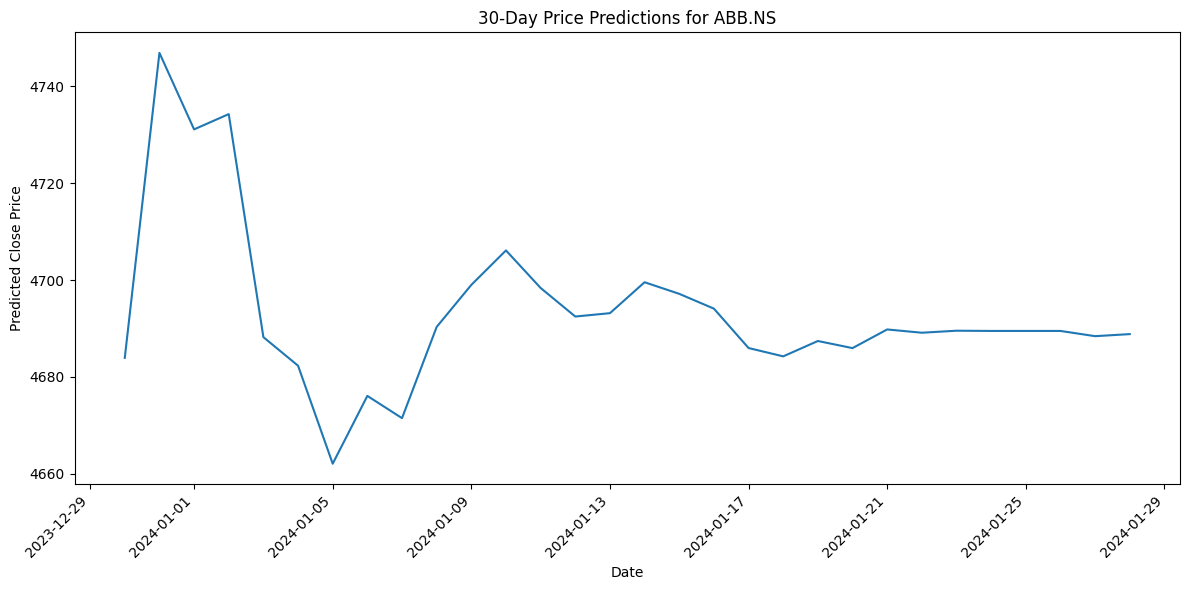

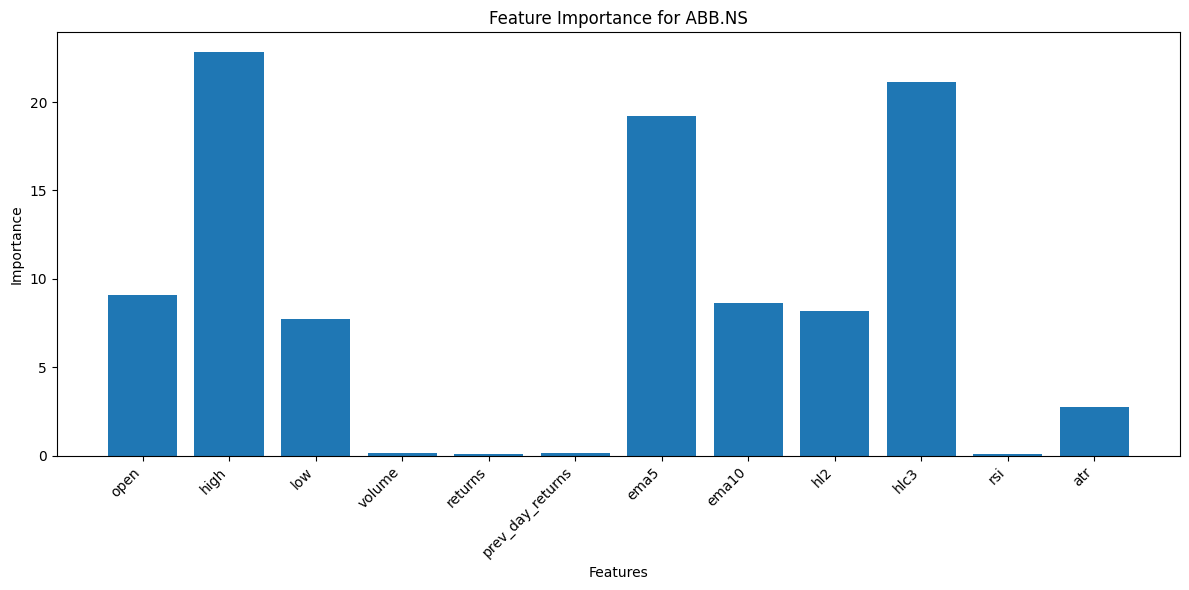

In [47]:
# Plot predictions for a sample symbol (e.g., the first one)
sample_symbol = list(results.keys())[0]
sample_predictions = results[sample_symbol]['predictions']

plt.figure(figsize=(12, 6))
plt.plot(sample_predictions.index, sample_predictions['predicted_close'])
plt.title(f"30-Day Price Predictions for {sample_symbol}")
plt.xlabel("Date")
plt.ylabel("Predicted Close Price")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot feature importance for the sample symbol
sample_model = results[sample_symbol]['model']
feature_importance = sample_model.feature_importances_
feature_names = sample_model.feature_names_

plt.figure(figsize=(12, 6))
plt.bar(feature_names, feature_importance)
plt.title(f"Feature Importance for {sample_symbol}")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [48]:
# Save results to a CSV file
all_predictions = pd.DataFrame()
for symbol, data in results.items():
    symbol_predictions = data['predictions'].copy()
    symbol_predictions['symbol'] = symbol
    all_predictions = pd.concat([all_predictions, symbol_predictions])

all_predictions.to_csv('nifty200_30day_predictions.csv')
print("Predictions saved to 'nifty200_30day_predictions.csv'")

Predictions saved to 'nifty200_30day_predictions.csv'


In [53]:
import pandas as pd
from sqlalchemy import create_engine, text

# Load the predictions
predictions_df = pd.read_csv('nifty200_30day_predictions.csv')

# Connect to the SQLite database
db_file_path = 'sqlite:///finance_symbols.db'
engine = create_engine(db_file_path, echo=False)

# Function to get the last known closing price for a symbol
def get_last_close(symbol):
    query = text(f"SELECT close FROM finance_data WHERE symbol = :symbol ORDER BY date DESC LIMIT 1")
    with engine.connect() as connection:
        result = connection.execute(query, {"symbol": symbol}).fetchone()
    return result[0] if result else None

# Create a new DataFrame to store the aggregate results
aggregate_results = []

# Process each unique symbol
for symbol in predictions_df['symbol'].unique():
    symbol_predictions = predictions_df[predictions_df['symbol'] == symbol]
    
    # Get the last predicted closing price (30th day)
    closing_price_30day = symbol_predictions['predicted_close'].iloc[-1]
    
    # Get the last known closing price
    last_known_close = get_last_close(symbol)
    
    if last_known_close is not None:
        # Calculate 30-day returns
        returns_30day = (closing_price_30day - last_known_close) / last_known_close * 100
    else:
        returns_30day = None
    
    # Append to results
    aggregate_results.append({
        'Stock': symbol,
        '30 day Closing': round(closing_price_30day, 2),
        '30 day returns': round(returns_30day, 2) if returns_30day is not None else None
    })

# Create DataFrame from aggregate results
aggregate_df = pd.DataFrame(aggregate_results)

# Sort by 30-day returns in descending order
aggregate_df = aggregate_df.sort_values('30 day returns', ascending=False)

aggregate_df

Stock  30 day Closing  30 day returns
126   MOTHERSON.NS          118.36           16.10
3           ACC.NS         2564.93           15.99
144    PETRONET.NS          252.40           13.36
52    DELHIVERY.NS          432.51           11.11
31   BERGEPAINT.NS          663.16            9.68
..             ...             ...             ...
104  KALYANKJIL.NS          201.92          -42.98
60         FACT.NS          443.23          -45.00
29          BDL.NS          457.81          -46.53
143  PERSISTENT.NS         1965.93          -46.79
170      SUZLON.NS           17.40          -54.46

[200 rows x 3 columns]

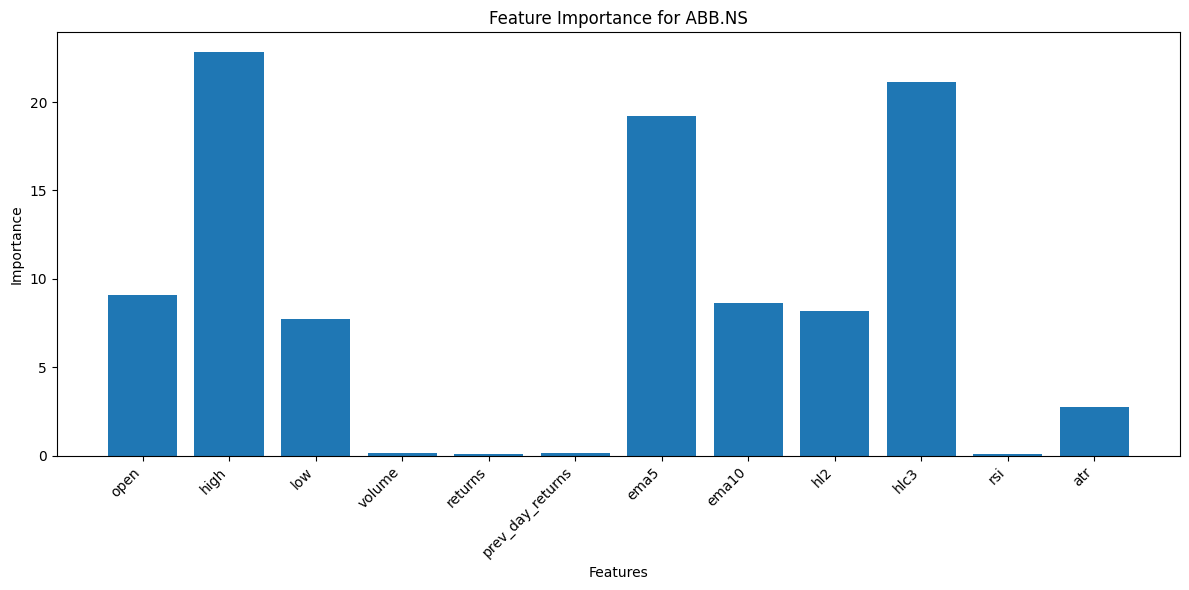

In [57]:
# Plot feature importance for a sample symbol (e.g., the first one)
sample_symbol = list(results.keys())[0]
sample_model = results[sample_symbol]['model']
feature_importance = sample_model.feature_importances_
feature_names = sample_model.feature_names_

plt.figure(figsize=(12, 6))
plt.bar(feature_names, feature_importance)
plt.title(f"Feature Importance for {sample_symbol}")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [55]:
# Save to CSV
aggregate_df.to_csv('aggregate_30day_predictions.csv', index=False)
print("Aggregate results saved to 'aggregate_30day_predictions.csv'")

# Save to SQLite database
aggregate_df.to_sql('aggregate_predictions', engine, if_exists='replace', index=False)
print("Aggregate results saved to 'aggregate_predictions' table in the database")

# Optional: Query and display the table from the database to confirm
print("\nConfirming data in the database:")
query_result = pd.read_sql_query("SELECT * FROM aggregate_predictions LIMIT 10", engine)
print(query_result)

Aggregate results saved to 'aggregate_30day_predictions.csv'
Aggregate results saved to 'aggregate_predictions' table in the database

Confirming data in the database:
           Stock  30 day Closing  30 day returns
0   MOTHERSON.NS          118.36           16.10
1         ACC.NS         2564.93           15.99
2    PETRONET.NS          252.40           13.36
3   DELHIVERY.NS          432.51           11.11
4  BERGEPAINT.NS          663.16            9.68
5     HAVELLS.NS         1450.33            6.02
6        LTIM.NS         6663.69            5.86
7         IOC.NS          137.10            5.58
8  PIDILITIND.NS         2865.65            5.54
9     SYNGENE.NS          738.47            5.28
